<a href="https://colab.research.google.com/github/jyothisivani/MiniProject/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Brain Tumor Prediction Model

In this notebook I applied Transfer Learning from MobileNetV2 so as to create a model which can detect. Transfer learning is important in Computer Vision tasks because we can not train a model from scratch because of small datasets which we have. Hence using pre trained models is essential neverthless you have a large dataset and prepare the model from scratch optimizing your hyperparameters and all and start a long journey

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
#Install required libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import os

In [ ]:
IMAGE_SIZE = 224 #Although our input images are 256 *256 we rescale them to 224*224 so we can use mobilenetv2
BATCH_SIZE = 16

### Load our images to tensorflow dataset

In [ ]:
#lets load the tf dataset using api. This function loads images from our specified directory and convert images to tensors
#having rgb values of each image and extracts the label for it.
dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/BrainTumorDataset/BrainTumorTypes",
    shuffle=True,
    # other parameters...
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 3064 files belonging to 3 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lets look at the labels of our dataset

In [ ]:
class_names = dataset.class_names
class_names

['glioma', 'meningioma', 'pituitary']

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(16, 224, 224, 3)
[0 0 1 2 0 0 0 1 1 1 1 2 0 1 1 0]


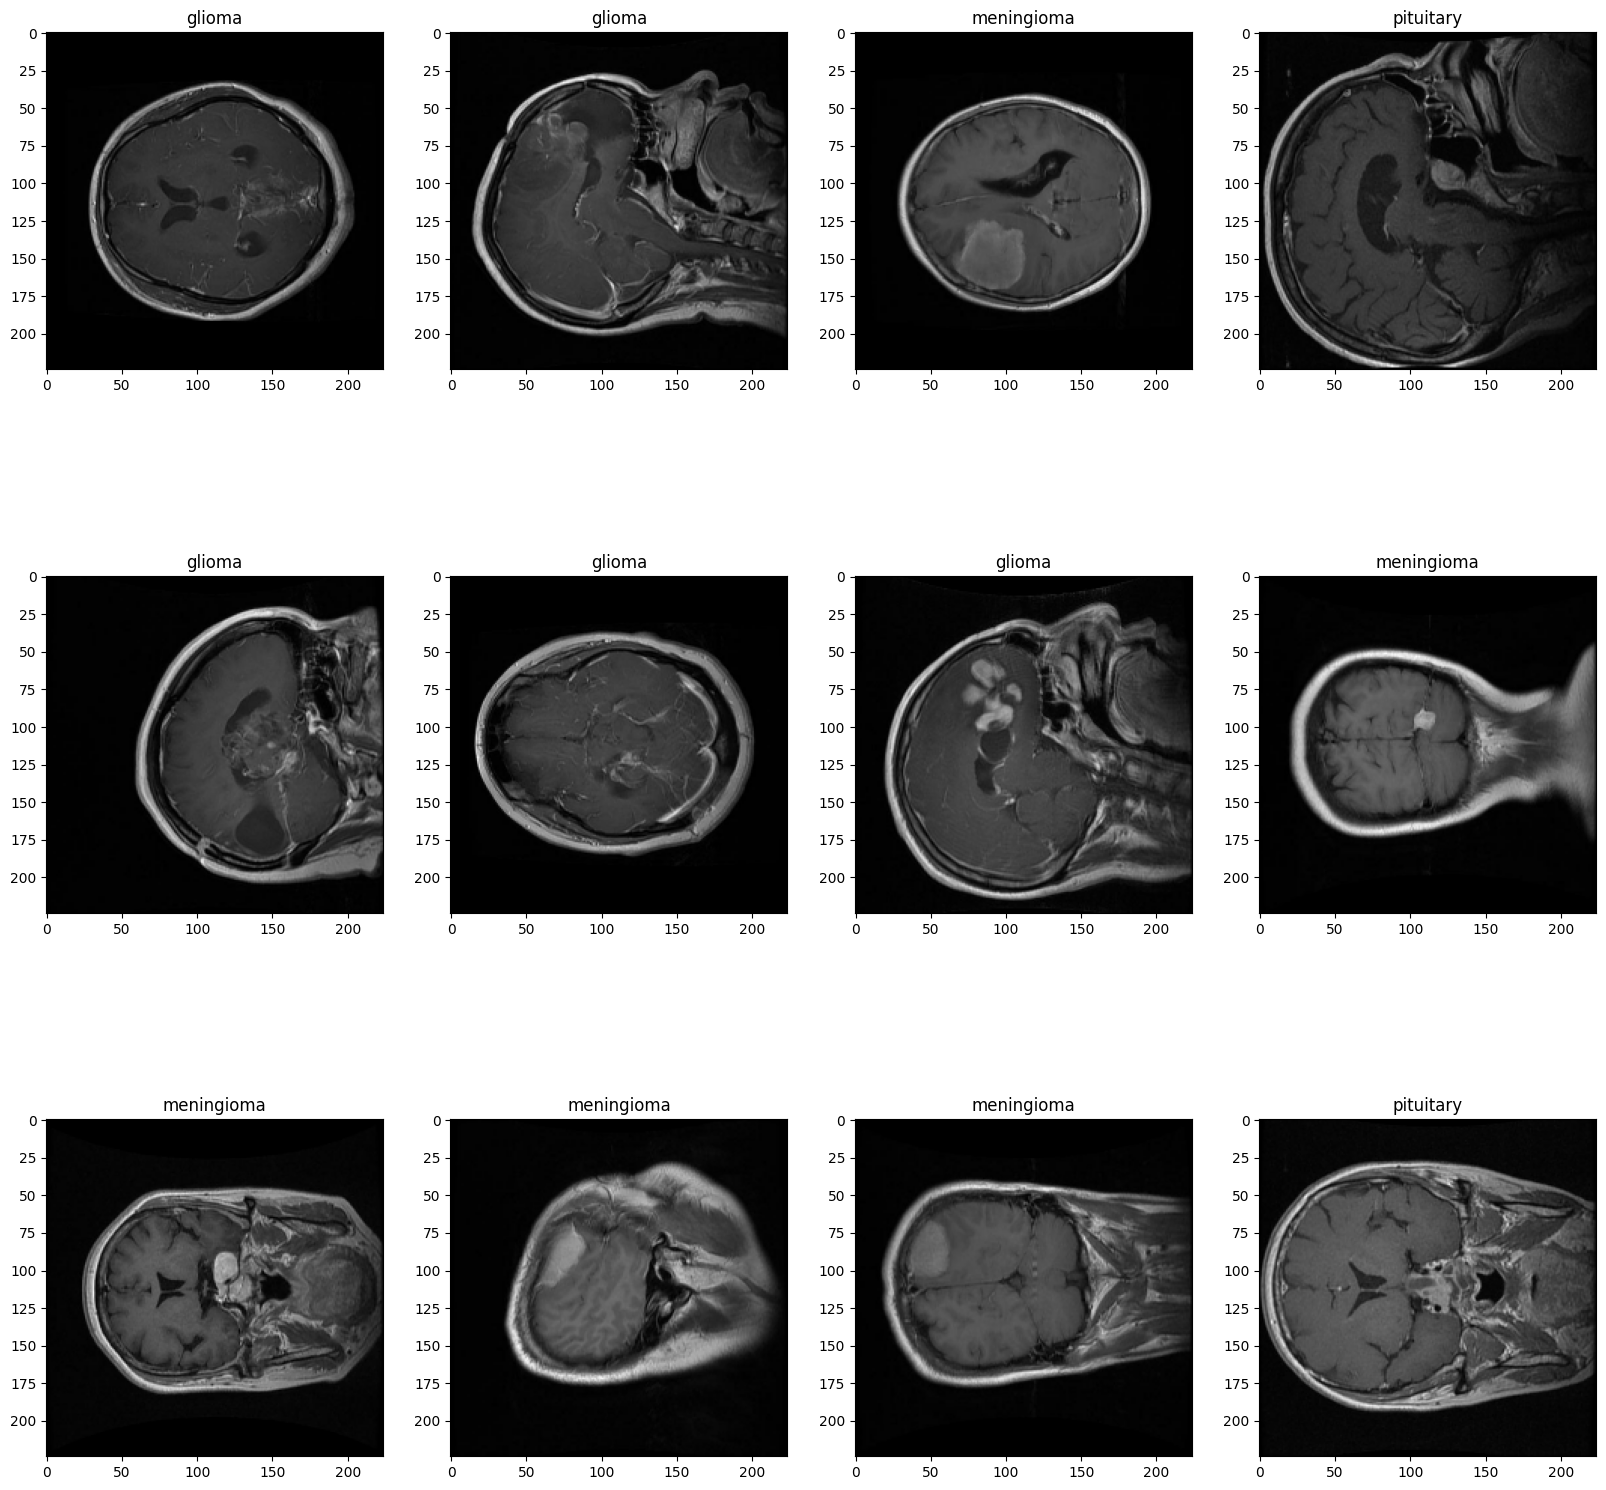

In [ ]:
plt.figure(figsize = (20,20)) # Lets increase plot size of our plots
#Lets explore our batch and display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)
    print(label_batch.numpy())

Look for the distribution of our class labels.

In [ ]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[1426  708  930]




Lets split our dataset into train, val, test sets to a ratio 7:2:1 of our tf dataset

In [ ]:
def get_partition(ds,train_split = 0.7, validate = 0.2,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
    train_size = int(train_split*ds_size)
    val_size = int(validate*ds_size)
    train = ds.take(train_size)
    val = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)
    return train,val,test

In [ ]:
train,val,test = get_partition(dataset)

In [ ]:
len(train)

134

Lets optimize tensorflow pipeline performance using prefetch and cache

In [ ]:
#It will read the image from the disk and for next iteration if you need the same image it will keep that image in memory
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.


Lets say we have one sample in our training data then we would create 4 samples out of it using horizontal flip, rotation,
zoom,contrasting and use all 5 images for training

In [ ]:
data_augment = tf.keras.Sequential(
[
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
train = train.map(lambda x, y: (data_augment(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

### IMPORTANT NOTE

Until now you have preprocessed your data but your pixel values lie between [0,255].But MobieNetv2 expects pixel values to lie between [-1,1] So you need to rescale your pixel values such that they lie between[-1,1]. You can use preprocess_input function to do so

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from pre-trained Mobilenet:

The very last layer contains classification layer which does classification. We do not want that layer so we exclude that layer and use remaining layers in our model. The last layer before flattening operation contains bottleneck layer.The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE =  (224,224)+ (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each 224x224x3 image into a 7x7x1280 block of features.

In [ ]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


## Feature extraction

In this step, you will freeze the convolutional base model created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.By setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

### Note about BatchNorm layers

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning.When you set layers.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.
When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


Lets add our softmax layer to generate predictions

In [ ]:
prediction_layer = tf.keras.layers.Dense(10, activation="softmax")

Build the entire model by applying data augmentation and then rescaling between -1 to 1 and then sending them to base model and then using global avg layer and prediction layer

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val)


38/38 [==============================] - 11s 33ms/step - loss: 2.4577 - accuracy: 0.1000


In [ ]:

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.46
initial accuracy: 0.10


In [ ]:
history = model.fit(train,epochs=initial_epochs,validation_data=val, batch_size = 16, verbose =1)

Epoch 1/10
134/134 [==============================] - 20s 125ms/step - loss: 1.4392 - accuracy: 0.4151 - val_loss: 0.9756 - val_accuracy: 0.5650
Epoch 2/10
134/134 [==============================] - 17s 125ms/step - loss: 0.9278 - accuracy: 0.5886 - val_loss: 0.7614 - val_accuracy: 0.6900
Epoch 3/10
134/134 [==============================] - 17s 125ms/step - loss: 0.7284 - accuracy: 0.6973 - val_loss: 0.6517 - val_accuracy: 0.7400
Epoch 4/10
134/134 [==============================] - 17s 125ms/step - loss: 0.6511 - accuracy: 0.7323 - val_loss: 0.5951 - val_accuracy: 0.7683
Epoch 5/10
134/134 [==============================] - 17s 127ms/step - loss: 0.6044 - accuracy: 0.7589 - val_loss: 0.5507 - val_accuracy: 0.7767
Epoch 6/10
134/134 [==============================] - 17s 127ms/step - loss: 0.5542 - accuracy: 0.7687 - val_loss: 0.5324 - val_accuracy: 0.7900
Epoch 7/10
134/134 [==============================] - 16s 123ms/step - loss: 0.5225 - accuracy: 0.7785 - val_loss: 0.5023 - val_ac

### NOTE:

If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

# Fine Tuning the model

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [ ]:
len(model.trainable_variables)

56

Continue training the model
If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 1
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train,epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val,batch_size = 16,verbose =1)

Epoch 10/11
134/134 [==============================] - 30s 137ms/step - loss: 0.4820 - accuracy: 0.8074 - val_loss: 0.2802 - val_accuracy: 0.8900
Epoch 11/11
134/134 [==============================] - 17s 130ms/step - loss: 0.2964 - accuracy: 0.8881 - val_loss: 0.2269 - val_accuracy: 0.9033


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

In [ ]:
acc = history.history['accuracy'] +history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] +  history_fine.history['val_loss']

Lets plot learning curves after fine tuning and check the difference

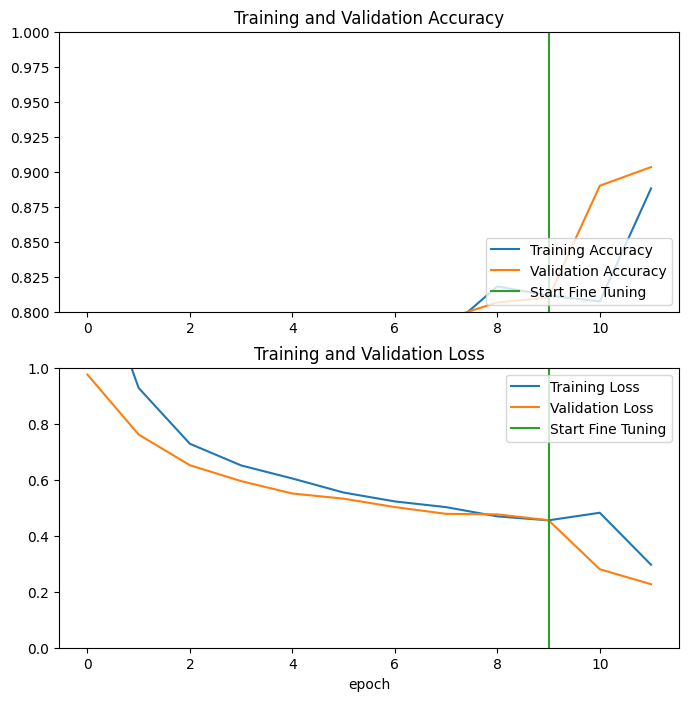

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to print
first image actual label: pituitary
1/1 [==============================] - 1s 1s/step
predicted label pituitary


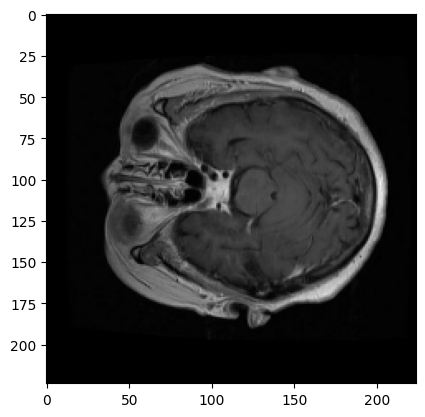

In [ ]:
for image_batch,label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to print")
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


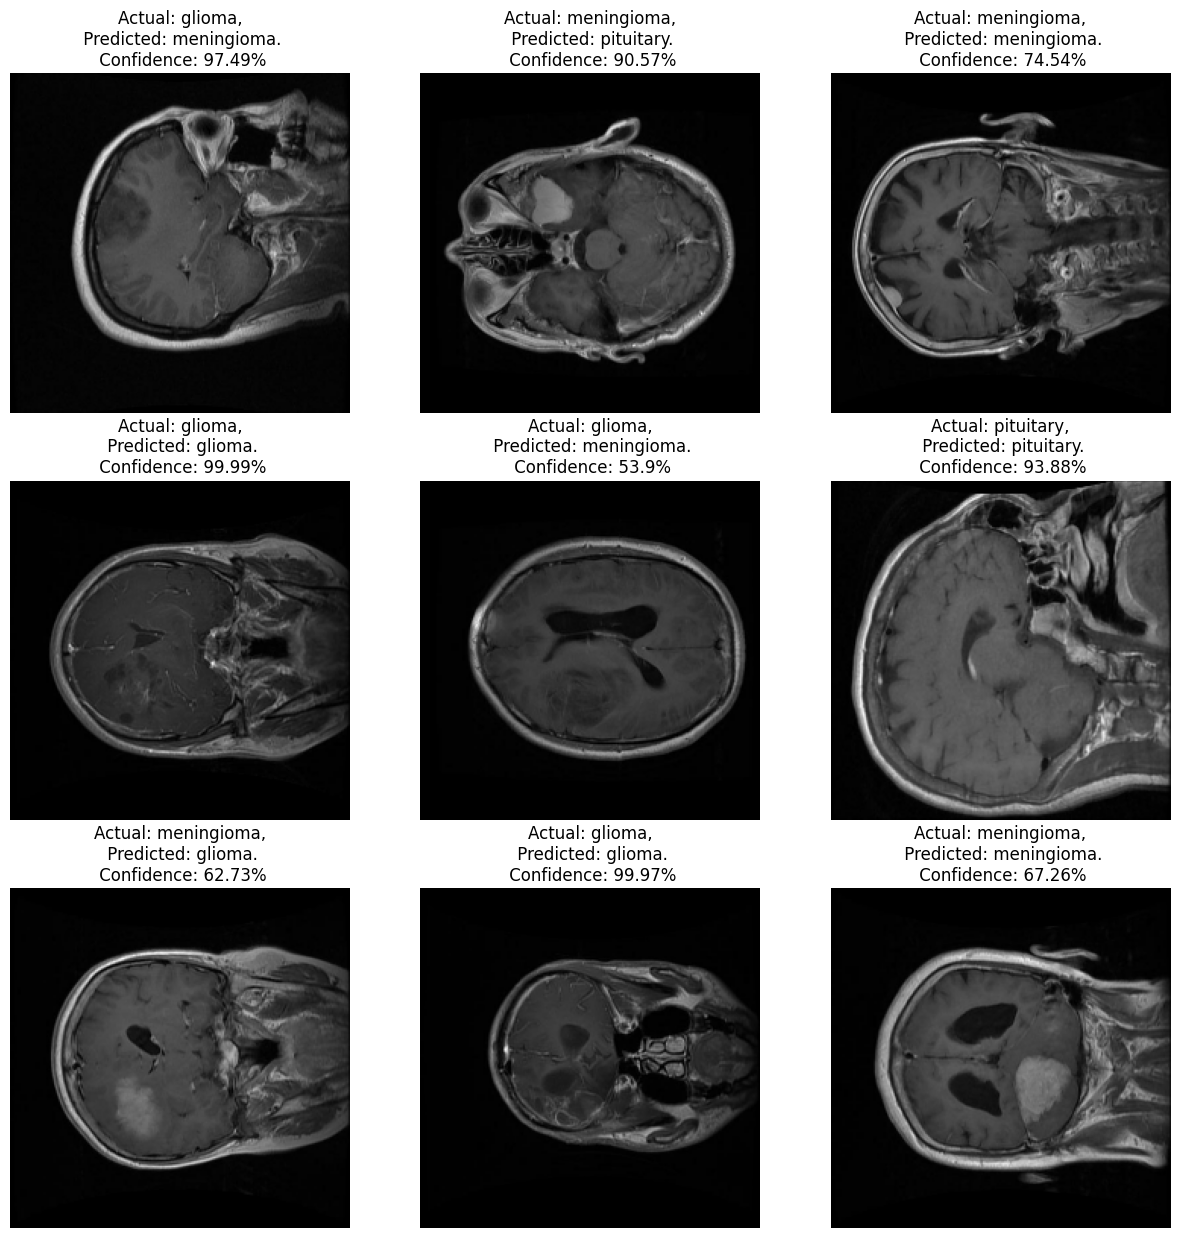

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

### Saving the model

In [ ]:
import os

models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

### References:
Many of this notebook's ideas inspired from the official documentation of tensorflow:
https://www.tensorflow.org/tutorials/images/transfer_learning
